In [81]:
import sqlite3
import os
from typing import Annotated, Literal, Any
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain_core.messages import AIMessage, ToolMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_groq import ChatGroq
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [82]:
# Initialize database connection
connection = sqlite3.connect("employee.db")

# Set up the Groq LLM
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama-3.3-70b-versatile")

# Initialize SQL database
db = SQLDatabase.from_uri("sqlite:///employee.db")

In [ ]:
# import sqlite3

# # Connect (creates employee.db if not exists)
# connection = sqlite3.connect("employee.db")
# cursor = connection.cursor()

# # --- Create tables ---
# cursor.executescript("""
# DROP TABLE IF EXISTS employees;
# DROP TABLE IF EXISTS customers;
# DROP TABLE IF EXISTS orders;

# CREATE TABLE employees (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     name TEXT NOT NULL,
#     position TEXT,
#     salary REAL
# );

# CREATE TABLE customers (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     first_name TEXT,
#     last_name TEXT,
#     phone TEXT
# );

# CREATE TABLE orders (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     customer_id INTEGER,
#     employee_id INTEGER,
#     order_date TEXT,
#     amount REAL,
#     FOREIGN KEY(customer_id) REFERENCES customers(id),
#     FOREIGN KEY(employee_id) REFERENCES employees(id)
# );
# """)

# # --- Insert sample data ---
# cursor.executemany(
#     "INSERT INTO employees (name, position, salary) VALUES (?, ?, ?)",
#     [
#         ("Alice Johnson", "Manager", 75000),
#         ("Bob Smith", "Sales", 48000),
#         ("Charlie Brown", "Engineer", 52000),
#         ("Diana Prince", "HR", 60000),
#     ],
# )

# cursor.executemany(
#     "INSERT INTO customers (first_name, last_name, phone) VALUES (?, ?, ?)",
#     [
#         ("John", "Smith", "555-1234"),
#         ("Jane", "Doe", "555-5678"),
#         ("Robert", "Brown", "555-9012"),
#     ],
# )

# cursor.executemany(
#     "INSERT INTO orders (customer_id, employee_id, order_date, amount) VALUES (?, ?, ?, ?)",
#     [
#         (1, 2, "2024-06-15", 120.50),
#         (2, 1, "2024-06-16", 340.75),
#         (3, 3, "2024-06-18", 85.00),
#     ],
# )

# connection.commit()
# connection.close()

# print("✅ Sample database created successfully!")


In [83]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    question: str
    table_info: str
    generated_query: str
    query_results: str
    error_message: str

# Define the final answer model
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

In [84]:
import sqlite3
conn = sqlite3.connect("employee.db")
cur = conn.cursor()
for row in cur.execute("SELECT name, salary FROM employees"):
    print(row)
conn.close()


('Alice Johnson', 75000.0)
('Bob Smith', 48000.0)
('Charlie Brown', 52000.0)
('Diana Prince', 60000.0)


In [85]:
# Tool to get table names and schemas
@tool
def get_tables_and_schemas() -> str:
    """
    Fetch all table names and their schemas from the database.
    Returns comprehensive information about all tables including structure and sample data.
    """
    try:
        # Get table names
        table_names = db.get_usable_table_names()
        
        # Get schema information for all tables
        schemas_info = []
        for table in table_names:
            schema_info = db.get_table_info_no_throw([table])
            schemas_info.append(f"Table: {table}\n{schema_info}")
        
        return "\n\n".join(schemas_info)
    except Exception as e:
        return f"Error fetching table information: {str(e)}"

In [86]:
print(get_tables_and_schemas.invoke({}))

Table: customers

CREATE TABLE customers (
	id INTEGER, 
	first_name TEXT, 
	last_name TEXT, 
	phone TEXT, 
	PRIMARY KEY (id)
)

/*
3 rows from customers table:
id	first_name	last_name	phone
1	John	Smith	555-1234
2	Jane	Doe	555-5678
3	Robert	Brown	555-9012
*/

Table: employees

CREATE TABLE employees (
	id INTEGER, 
	name TEXT NOT NULL, 
	position TEXT, 
	salary REAL, 
	PRIMARY KEY (id)
)

/*
3 rows from employees table:
id	name	position	salary
1	Alice Johnson	Manager	75000.0
2	Bob Smith	Sales	48000.0
3	Charlie Brown	Engineer	52000.0
*/

Table: orders

CREATE TABLE orders (
	id INTEGER, 
	customer_id INTEGER, 
	employee_id INTEGER, 
	order_date TEXT, 
	amount REAL, 
	PRIMARY KEY (id), 
	FOREIGN KEY(customer_id) REFERENCES customers (id), 
	FOREIGN KEY(employee_id) REFERENCES employees (id)
)

/*
3 rows from orders table:
id	customer_id	employee_id	order_date	amount
1	1	2	2024-06-15	120.5
2	2	1	2024-06-16	340.75
3	3	3	2024-06-18	85.0
*/


In [87]:
@tool
def execute_sql_query(query: str) -> str:
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    """
    try:
        result = db.run_no_throw(query)
        if not result:
            return "Error: Query returned no results or failed to execute. Please check your SQL syntax."
        return str(result)
    except Exception as e:
        return f"Error executing query: {str(e)}"

In [88]:
print(execute_sql_query("Select * from customers"))

[(1, 'John', 'Smith', '555-1234'), (2, 'Jane', 'Doe', '555-5678'), (3, 'Robert', 'Brown', '555-9012')]


In [89]:
def query_generator_node(state: State) -> dict:
    """
    Node that generates SQL queries, executes them, and handles errors with retry logic.
    """
    question = state.get("question", "")
    table_info = state.get("table_info", "")
    error_message = state.get("error_message", "")
    
    # Prepare the prompt for query generation
    if error_message:
        prompt_text = f"""
        You are a SQL expert. The previous query failed with this error: {error_message}
        
        Based on the table information below, generate a corrected SQL query for: {question}
        
        Table Information:
        {table_info}
        
        Rules:
        - Generate only valid SQLite syntax
        - Use proper table and column names as shown in the schema
        - Limit results to 5 unless specifically asked for more
        - Do not use any DML statements (INSERT, UPDATE, DELETE, DROP)
        - Only return the SQL query, no explanation
        """
    else:
        prompt_text = f"""
        You are a SQL expert. Based on the table information below, generate a SQL query for: {question}
        
        Table Information:
        {table_info}
        
        Rules:
        - Generate only valid SQLite syntax
        - Use proper table and column names as shown in the schema
        - Limit results to 5 unless specifically asked for more
        - Do not use any DML statements (INSERT, UPDATE, DELETE, DROP)
        - Only return the SQL query, no explanation
        """
    
    # Generate the query
    query_response = llm.invoke(prompt_text)
    generated_query = query_response.content.strip()
    
    # Clean the query (remove any markdown formatting)
    if "```sql" in generated_query:
        generated_query = generated_query.split("```sql")[1].split("```")[0].strip()
    elif "```" in generated_query:
        generated_query = generated_query.split("```")[1].strip()
    
    # Execute the query
    query_results = execute_sql_query.invoke({"query": generated_query})
    
    # Check if there was an error
    if query_results.startswith("Error"):
        return {
            "generated_query": generated_query,
            "error_message": query_results,
            "messages": [AIMessage(content=f"Query failed: {generated_query}. Error: {query_results}")]
        }
    
    # If successful, generate final answer
    final_answer_prompt = f"""
    Based on the SQL query results below, provide a clear, natural language answer to the user's question: {question}
    
    Query executed: {generated_query}
    Results: {query_results}
    
    Provide a concise, human-readable answer that directly addresses the user's question.
    """
    
    final_response = llm.invoke(final_answer_prompt)
    
    return {
        "generated_query": generated_query,
        "query_results": query_results,
        "error_message": "",
        "messages": [AIMessage(
            content="Query executed successfully.",
            tool_calls=[{
                "name": "SubmitFinalAnswer",
                "args": {"final_answer": final_response.content},
                "id": "final_answer"
            }]
        )]
    }


In [90]:
def should_continue(state: State) -> Literal["query_generator", END]:
    """
    Determine whether to continue processing or end the conversation.
    """
    error_message = state.get("error_message", "")
    messages = state.get("messages", [])
    
    # If there's an error, retry query generation
    if error_message and not error_message == "":
        return "query_generator"
    
    # If the last message has tool calls (final answer), end
    if messages and hasattr(messages[-1], 'tool_calls') and messages[-1].tool_calls:
        return END
    
    # Otherwise, continue to query generator
    return "query_generator"

In [91]:
def fetch_table_info_node(state: State) -> dict:
    table_info = get_tables_and_schemas.invoke({})
    return {"table_info": table_info, "messages": state.get("messages", [])}


In [92]:
def build_sql_agent():
    """
    Build and return the SQL agent workflow.
    """
    workflow = StateGraph(State)
    
    # Add nodes
    workflow.add_node("fetch_table_info", fetch_table_info_node)
    workflow.add_node("query_generator", query_generator_node)
    
    # Add edges
    workflow.add_edge(START, "fetch_table_info")
    workflow.add_edge("fetch_table_info", "query_generator")
    workflow.add_conditional_edges(
        "query_generator",
        should_continue,
        {
            "query_generator": "query_generator",
            END: END
        }
    )
    
    return workflow.compile()


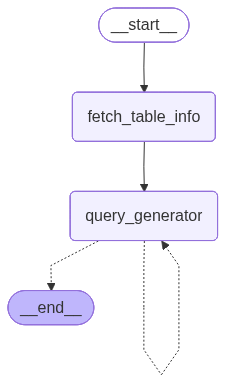

In [93]:
app = build_sql_agent()
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [94]:
def run_sql_agent(question: str):
    """
    Run the SQL agent with a given question.
    """
    
    initial_state = {
        "messages": [AIMessage(content=f"User question: {question}")],
        "question": question,
        "table_info": "",
        "generated_query": "",
        "query_results": "",
        "error_message": ""
    }
    
    result = app.invoke(initial_state)
    
    # Extract the final answer
    final_message = result["messages"][-1]
    if hasattr(final_message, 'tool_calls') and final_message.tool_calls:
        return final_message.tool_calls[0]["args"]["final_answer"]
    else:
        return "Sorry, I couldn't generate an answer for your question."

In [96]:
questions = [
        "Tell me name of the employee who's salary is more than 50000?",
        "Tell me name of the employee who's salary is less than 50000?",
        
        "Show me all the orders",
        "What are the phone numbers of customers whose last name is 'Smith'?"
    ]
    
for question in questions:
        print(f"\nQuestion: {question}")
        answer = run_sql_agent(question)
        print(f"Answer: {answer}")
        print("-" * 50)


Question: Tell me name of the employee who's salary is more than 50000?
Answer: The employees who have a salary of more than $50,000 are Alice Johnson, Charlie Brown, and Diana Prince.
--------------------------------------------------

Question: Tell me name of the employee who's salary is less than 50000?
Answer: The employee whose salary is less than 50,000 is Bob Smith.
--------------------------------------------------

Question: Show me all the orders
Answer: Here are the orders: 
1. Order 1 was placed on June 15, 2024, for customer 1, with seller 2, and a total of $120.50.
2. Order 2 was placed on June 16, 2024, for customer 2, with seller 1, and a total of $340.75.
3. Order 3 was placed on June 18, 2024, for customer 3, with seller 3, and a total of $85.00.
--------------------------------------------------

Question: What are the phone numbers of customers whose last name is 'Smith'?
Answer: The phone number of the customer with the last name 'Smith' is 555-1234.
------------